In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from IPython.display import clear_output

BATCH_SIZE = 4

format = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    transforms.RandomCrop((400, 400)),
    transforms.RandomRotation(180),

    transforms.CenterCrop((282, 282)), # 282 ~= 400 * (1/sqrt(2))
    transforms.Resize((256, 256), transforms.InterpolationMode.NEAREST),

    transforms.RandomApply(p=0.2, transforms=[transforms.GaussianBlur(5, sigma=(.5, 12))]),
    transforms.RandomApply(p=0.2, transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.5)]),

    transforms.ToTensor(),
])

ds = datasets.Flowers102(root='../pytorch-datasets/', split='train', transform=format, download=True)
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

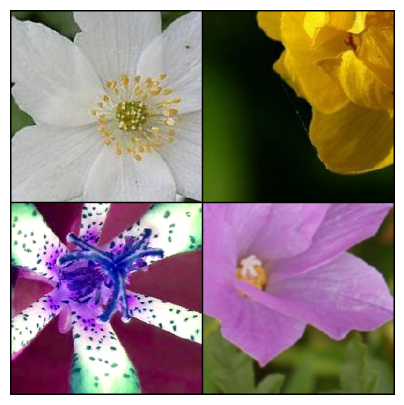

In [ ]:
for b, l in dl:
    plt.figure(figsize=(5, 5))
    plt.imshow(make_grid(b, nrow=2).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    break

In [98]:
data = b
save_image(make_grid(data, nrow=2), 'data.png')

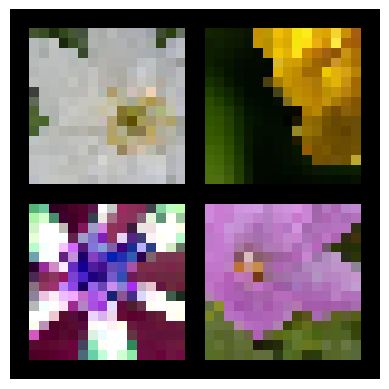

In [81]:
KEY_SIZE = torch.Size((16, 16))
key = F.interpolate(data, size=KEY_SIZE, mode='nearest')
save_image(make_grid(key, nrow=2), 'key.png')
plt.imshow(make_grid(key, nrow=2).permute(1, 2, 0))
plt.axis('off')
plt.show()

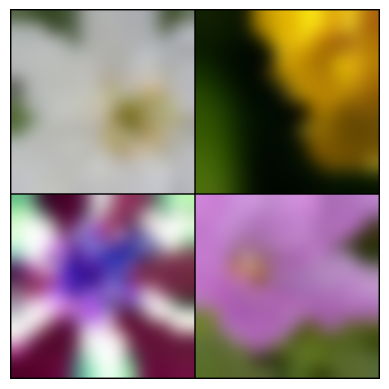

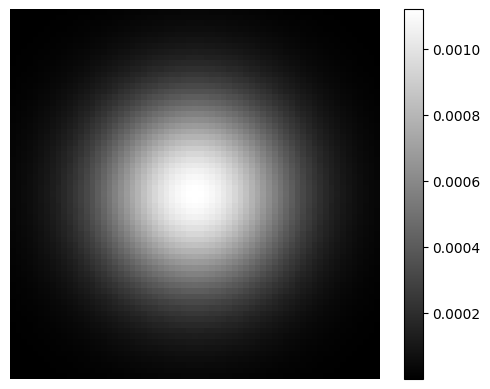

In [82]:
basis = F.interpolate(key, size=(256, 256), mode='nearest')

PAD_SIZE = 32
kernel_size = 2*PAD_SIZE + 1

x = torch.arange(-PAD_SIZE, PAD_SIZE+1).float()

std = 12
sig2 = std*std * 2

kernel = torch.exp(-x**2 / sig2) / math.sqrt(2*math.pi)
kernel = torch.outer(kernel, kernel)
kernel = kernel / kernel.sum()
kernel = kernel[None, None, :, :].repeat(3, 1, 1, 1)

# Note: can be sped up by doing horizontal and vertical
# gaussian convolutions separately instead of using outer product

basis = F.pad(basis, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE), mode='reflect')
basis = F.conv2d(basis, kernel, groups=3, padding=0, stride=1)

save_image(basis, 'basis.png')

plt.imshow(make_grid(basis.cpu(), nrow=2).permute(1, 2, 0))
plt.axis('off')
plt.show()
plt.imshow(kernel[0, 0], cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

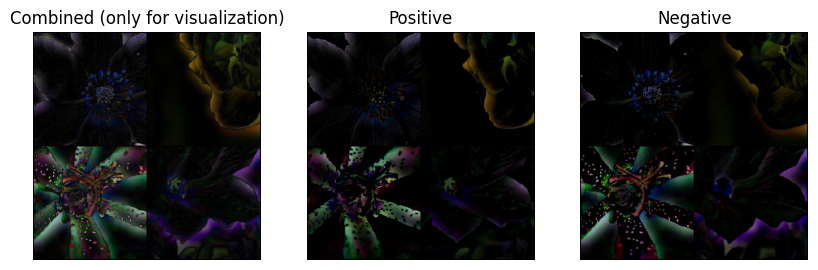

In [83]:
target = data - basis
# target_img = (target - torch.min(target)) / (torch.max(target) - torch.min(target))
target_abs = torch.clamp(torch.abs(target), 0, 1)
target_pos = torch.clamp(target, 0, 1)
target_neg = torch.clamp(-target, 0, 1)
save_image(target_abs, 'target.png')
ax, fig = plt.subplots(1, 3, figsize=(10, 3))
fig[0].set_title('Combined (only for visualization)')
fig[0].imshow(make_grid(target_abs, nrow=2).permute(1, 2, 0).numpy())
fig[0].axis('off')
fig[1].set_title('Positive')
fig[1].imshow(make_grid(target_pos, nrow=2).permute(1, 2, 0).numpy())
fig[1].axis('off')
fig[2].set_title('Negative')
fig[2].imshow(make_grid(target_neg, nrow=2).permute(1, 2, 0).numpy())
fig[2].axis('off')
plt.show()
# plt.imshow(make_grid(target_img, nrow=2).permute(1, 2, 0).numpy())
# plt.axis('off')
# plt.show()

In [93]:
class SineActivation(nn.Module):
    def __init__(self):
        super(SineActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x)


class Learner(nn.Module):
    def __init__(self, key_size):
        super(Learner, self).__init__()
        self.key_size = key_size

        self.decoder = nn.Sequential(

            # nn.ConvTranspose2d(3, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(16, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            # nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(64, 16, kernel_size=7, stride=2, padding=3, output_padding=1),
            # nn.ReLU(inplace=True),
            # nn.ConvTranspose2d(16, 3, kernel_size=9, stride=2, padding=4, output_padding=1),

            nn.Flatten(2),

            nn.Linear(16*16, 512),
            # nn.ReLU(inplace=True),
            SineActivation(),

            nn.Linear(512, 768),
            # nn.ReLU(inplace=True),
            SineActivation(),

            nn.Linear(768, 32*32),
            # nn.ReLU(inplace=True),
            SineActivation(),


            nn.Unflatten(2, (32, 32)),

            # nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # 16 -> 32
            # nn.ReflectionPad2d(1),
            # nn.Conv2d(3, 16, kernel_size=3),
            # nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # 32 -> 64
            nn.ReflectionPad2d(2),
            nn.Conv2d(3, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # 64 -> 128
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 64, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # 128 -> 256
            nn.ReflectionPad2d(4),
            nn.Conv2d(64, 3, kernel_size=9), 

            # nn.Flatten(2),

            # nn.Linear(256 * 256, 256 * 256),
            # nn.ReLU(inplace=True),
            # nn.Linear(256 * 256, 256 * 256),

            # nn.Unflatten(2, (256, 256))

            # nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # 256 -> 512
            # nn.ReflectionPad2d(3),
            # nn.Conv2d(16, 8, kernel_size=7),
            # nn.ReflectionPad2d(2),
            # nn.Conv2d(8, 6, kernel_size=5),
            # nn.ReflectionPad2d(1),
            # nn.Conv2d(6, 3, kernel_size=3),
            # nn.AvgPool2d(2, stride=2),
            )

    def forward(self, x):
        y = self.decoder(x)
        return y

In [94]:
key = key.cuda()
target = target.cuda()

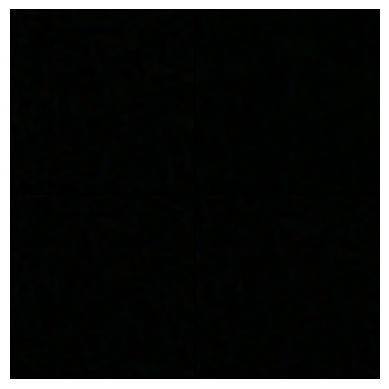

torch.Size([4, 3, 256, 256])

In [95]:
model = Learner(KEY_SIZE).cuda()
with torch.no_grad():
    pred = torch.clamp(torch.abs(model(key)), 0, 1)
    save_image(make_grid(pred, nrow=2), 'pred.png')
    plt.imshow(make_grid(pred, nrow=2).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()
pred.shape

In [96]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

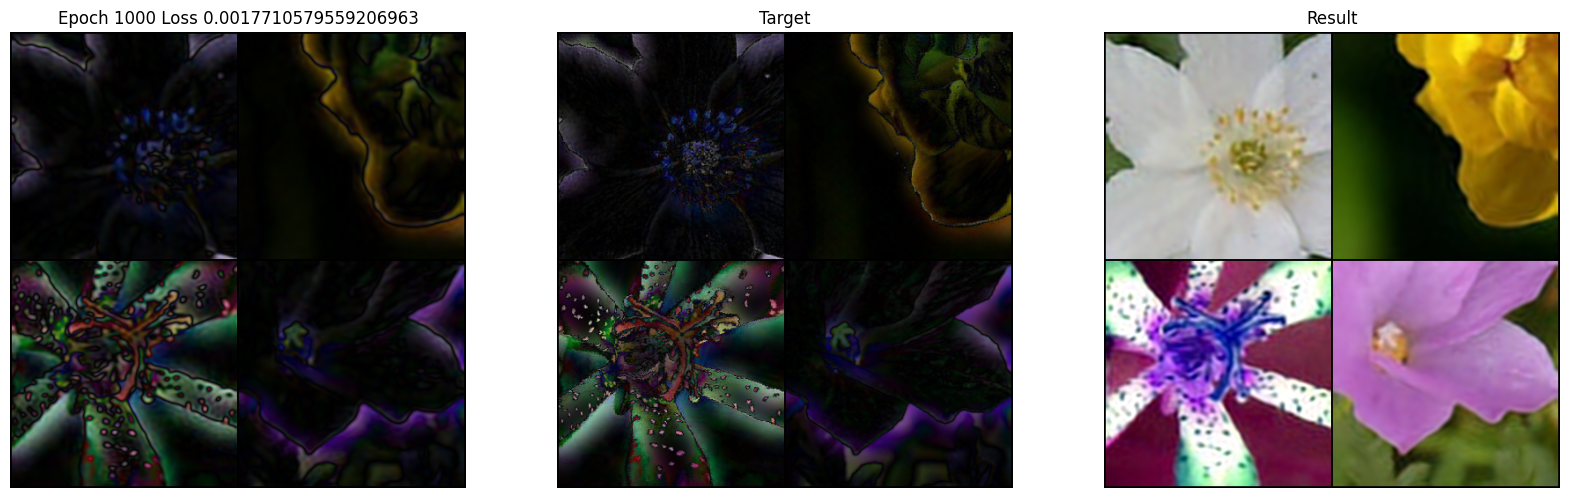

In [97]:
EPOCHS = 1000

model.train()
torch.set_grad_enabled(True)

for epoch in range(1, EPOCHS+1):
    pred = model(key)
    loss = criterion(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        clear_output(wait=True)

        with torch.no_grad():
            result = torch.clamp(basis.cuda() + pred, 0, 1)
            pred = torch.clamp(torch.abs(pred), 0, 1)

        ax, fig = plt.subplots(1, 3, figsize=(20, 6))
        fig[0].set_title(f'Epoch {epoch} Loss {loss.item()}')
        fig[0].imshow(make_grid(pred, nrow=2).permute(1, 2, 0).cpu())
        fig[0].axis('off')
        fig[1].set_title('Target')
        fig[1].imshow(make_grid(target_abs, nrow=2).permute(1, 2, 0).cpu())
        fig[1].axis('off')
        fig[2].set_title('Result')
        fig[2].imshow(make_grid(result, nrow=2).permute(1, 2, 0).cpu())
        fig[2].axis('off')
        
        plt.show()

In [99]:
torch.set_grad_enabled(False)
model.eval()

pred = model(key)
out = basis + pred.cpu()
save_image(make_grid(out, nrow=2), 'out.png')